In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
%load_ext rpy2.ipython
%R library(ggplot2)

R[write to console]: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang



array(['ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U9')

In [3]:
ab = pd.read_csv('../data/pitch/atbats.csv')

In [4]:
ab.head()

,ab_id,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top
0,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,True
1,2015000002,518792,Double,201500001,1,1,0,L,452657,L,True
2,2015000003,407812,Single,201500001,1,1,0,L,452657,R,True
3,2015000004,425509,Strikeout,201500001,1,2,0,L,452657,R,True
4,2015000005,571431,Strikeout,201500001,1,3,0,L,452657,L,True


In [5]:
ab2018 = ab.loc[ab.ab_id.astype(str).str.startswith('2018')]

In [6]:
names = pd.read_csv('../data/pitch/player_names.csv')

In [7]:
named_ab = pd.merge(ab2018, names, left_on = 'batter_id', right_on = 'id', how = 'left')

In [8]:
## American Leage
first, last = ['Mookie', 'Mike', 'Jose', 'J.D.', 'Alex'], ['Betts', 'Trout', 'Ramirez', 'Martinez', 'Bregman']
mvps = named_ab.loc[(named_ab.first_name.isin(first)) & (named_ab.last_name.isin(last))]

In [9]:
trout = mvps.loc[mvps.last_name == 'Trout']
betts = mvps.loc[mvps.last_name == 'Betts']
martinez = mvps.loc[(mvps.last_name == 'Martinez') & (mvps.first_name == 'J.D.')]
ramirez = mvps.loc[mvps.last_name == 'Ramirez']
bregman = mvps.loc[mvps.last_name == 'Bregman']

In [10]:
## National League
last = ['Yelich', 'Baez', 'Arenado']
NLmvps = named_ab.loc[(named_ab.last_name.isin(last)) & (named_ab.first_name != 'Pedro')]

In [11]:
yelich = NLmvps.loc[NLmvps.last_name == 'Yelich']
baez = NLmvps.loc[NLmvps.last_name == 'Baez']
arenado = NLmvps.loc[NLmvps.last_name == 'Arenado']

In [12]:
mvps.event.unique()

array(['Groundout', 'Flyout', 'Pop Out', 'Strikeout', 'Walk', 'Single',
       'Forceout', 'Grounded Into DP', 'Double', 'Home Run', 'Lineout',
       'Runner Out', 'Fielders Choice', 'Hit By Pitch', 'Sac Fly',
       'Triple', 'Intent Walk', 'Field Error', 'Batter Interference',
       'Fielders Choice Out', 'Double Play', 'Strikeout - DP',
       'Catcher Interference', 'Sac Bunt'], dtype=object)

#  clean up code, yikes

In [13]:
on_base = ['Walk', 'Single', 'Double', 'Home Run', 'Hit By Pitch', 'Triple', 'Intent Walk']

In [14]:
def game_count(df):
    ct = [1]
    i = 1
    for j, game_id in enumerate(df.iloc[1:,3]):
        if game_id == df.iloc[j,3]:
            ct.append(i)
        else:
            i += 1
            ct.append(i)
    df['game_count'] = ct
    return df

In [15]:
def on_base_pct(df, roll):
    df['on_base_flag'] = np.where(df.event.isin(on_base), 1, 0)
    df['ob_pct'] = df.on_base_flag.rolling(roll).sum() / roll
    return df

In [16]:
def hr_sum(df, roll):
    df['HR'] = np.where(df.event == 'Home Run', 1, 0)
    df['HR_rolling'] = df.HR.rolling(roll).sum()
    return df

In [17]:
def slugging(df, roll):
    df['total_bases'] = 0
    df.loc[(df.event.isin(['Walk', 'Single', 'Hit By Pitch', 'Intent Walk'])), 'total_bases'] = 1
    df.loc[df.event == 'Double', 'total_bases'] = 2
    df.loc[df.event == 'Triple', 'total_bases'] = 3
    df.loc[df.event == 'Home Run', 'total_bases'] = 4
    df['Slugging'] = df.total_bases.rolling(roll).mean()
    return df

In [18]:
def create_cols(df, roll):
    df = game_count(df) # create game # index
    df['ab_num'] = df.reset_index().index + 1 - roll # create ab bat index
    df = on_base_pct(df, roll) # create on base percentage over rolling n at bats
    df = hr_sum(df, roll) # create sum of HR's over rolling n at bats
    df = slugging(df, roll)  # create slugging percentage, ie total bases / at bats
    df['obps'] = df.ob_pct + df.Slugging # create obp+s
    df = df[['first_name', 'last_name', 'game_count', 'ab_num', 'event','on_base_flag', 'ob_pct', 
             'Slugging', 'obps', 'HR_rolling']] # keep only desired columns
    df = df.dropna() # drop na rows
    #df = df.loc[df.game_num % 5 == 0]
    return df

In [19]:
## AL
trout = create_cols(trout, 100)
betts = create_cols(betts, 100)
martinez = create_cols(martinez, 100)
ramirez = create_cols(ramirez, 100)
bregman = create_cols(bregman, 100)

In [20]:
combined = pd.concat([trout, betts, martinez, ramirez, bregman])
combined.head()

,first_name,last_name,game_count,ab_num,event,on_base_flag,ob_pct,Slugging,obps,HR_rolling
24101,Mike,Trout,22,0,Strikeout,0,0.40,0.69,1.09,8.0
24120,Mike,Trout,22,1,Home Run,1,0.41,0.73,1.14,9.0
24275,Mike,Trout,23,2,Strikeout,0,0.41,0.73,1.14,9.0
24296,Mike,Trout,23,3,Flyout,0,0.41,0.73,1.14,9.0
24312,Mike,Trout,23,4,Single,1,0.42,0.74,1.16,9.0


In [21]:
## NL
yelich = create_cols(yelich, 50)
baez = create_cols(baez, 50)
arenado = create_cols(arenado, 50)

In [26]:
def grouping(df):
    df = df.groupby(['game_count','last_name']).agg('mean')[['ob_pct', 'Slugging', 'obps', 'HR_rolling']].reset_index()
    return df

In [28]:
yelich = grouping(yelich)
baez = grouping(baez)
arenado = grouping(arenado)

In [29]:
combinedNL = pd.concat([yelich, baez, arenado])
combinedNL.loc[combinedNL.last_name == 'Yelich', 'winnerFlag'] = 'won'
combinedNL.loc[combinedNL.last_name != 'Yelich', 'winnerFlag'] = 'no'
combinedNL.head()

,game_count,last_name,ob_pct,Slugging,obps,HR_rolling,winnerFlag
0,11,Yelich,0.420,0.620,1.040,2.0,won
1,12,Yelich,0.404,0.604,1.008,2.0,won
2,13,Yelich,0.432,0.632,1.064,2.0,won
3,14,Yelich,0.410,0.605,1.015,2.0,won
4,15,Yelich,0.345,0.525,0.870,2.0,won


In [36]:
yelich.head(100)

,game_count,last_name,ob_pct,Slugging,obps,HR_rolling
0,11,Yelich,0.420000,0.620000,1.040000,2.00
1,12,Yelich,0.404000,0.604000,1.008000,2.00
2,13,Yelich,0.432000,0.632000,1.064000,2.00
3,14,Yelich,0.410000,0.605000,1.015000,2.00
4,15,Yelich,0.345000,0.525000,0.870000,2.00
5,16,Yelich,0.340000,0.520000,0.860000,2.00
6,17,Yelich,0.310000,0.445000,0.755000,1.50
7,18,Yelich,0.304000,0.404000,0.708000,1.00
8,19,Yelich,0.310000,0.410000,0.720000,1.00
9,20,Yelich,0.288000,0.432000,0.720000,1.60


In [30]:
%R -i combinedNL

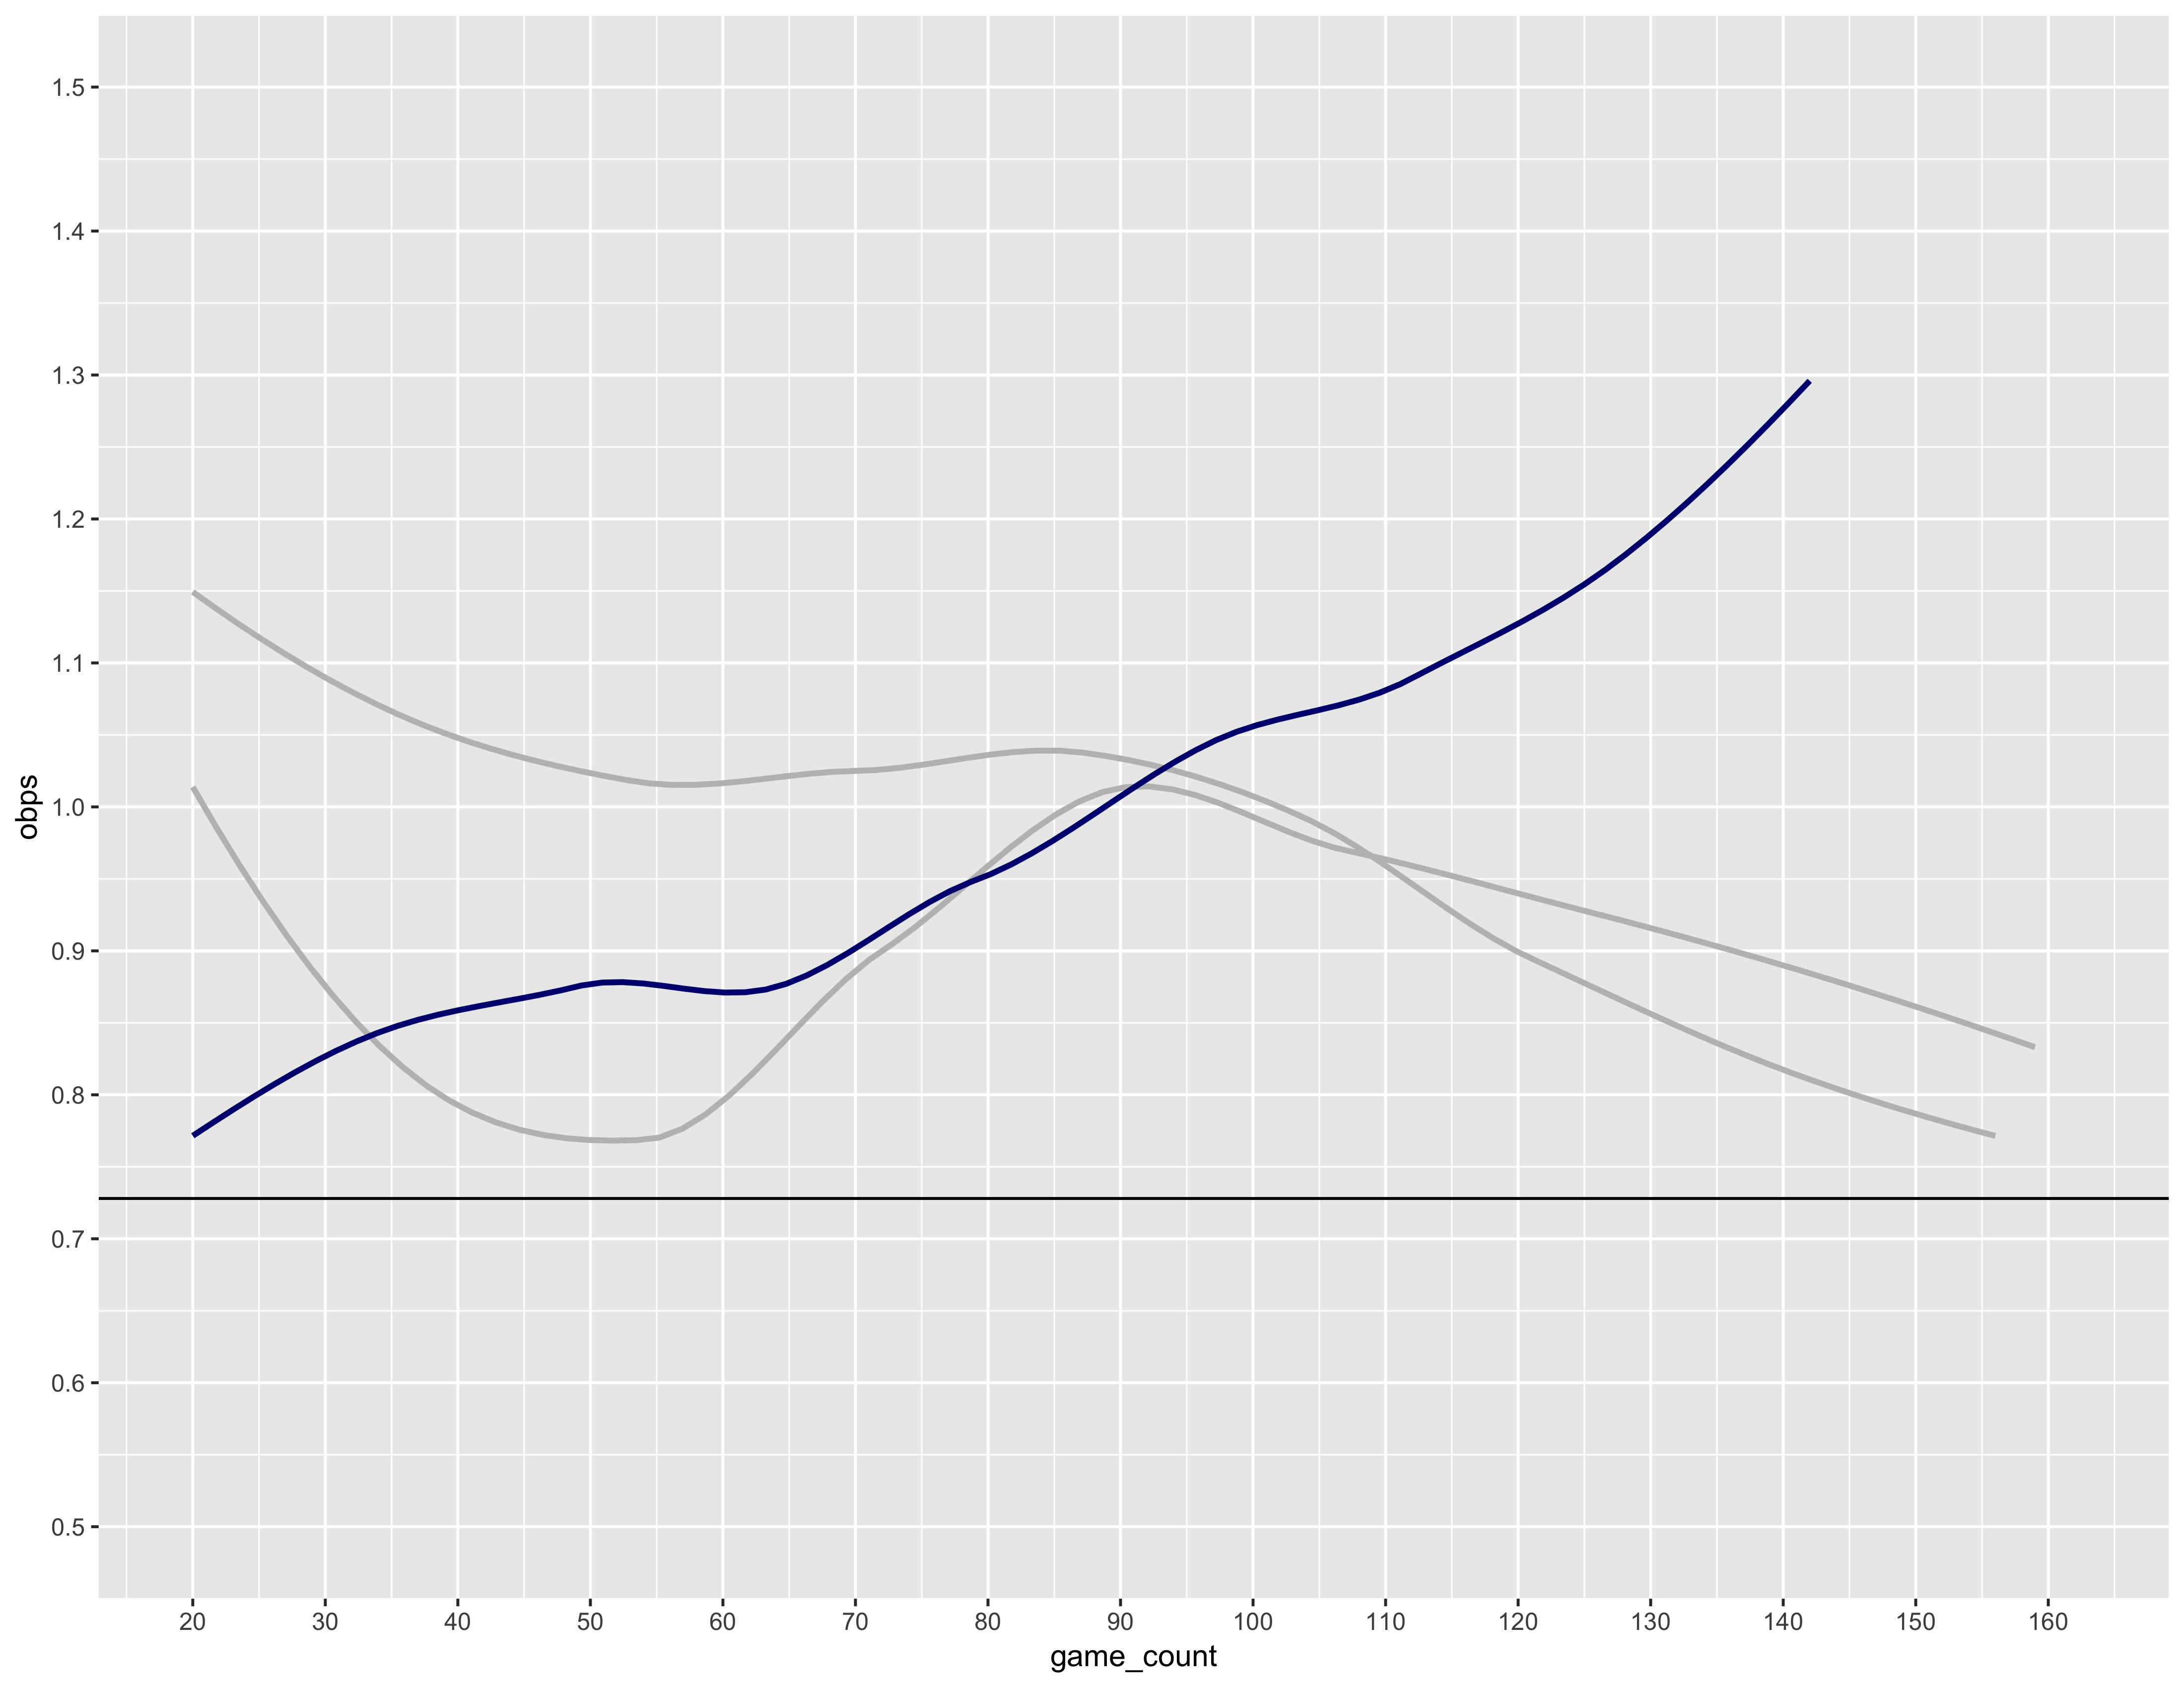

In [52]:
%%R -w 11 -h 8.5 --units in -r 400

ggplot() + geom_smooth(aes(x=game_count, y = obps, group = last_name, color = winnerFlag), 
                       data = combinedNL, method = 'loess', formula = 'y ~ x', se = F) +
        geom_hline(yintercept = 0.728) +
        scale_color_manual(values = c('grey', 'navyblue')) +
        scale_x_continuous(limits = c(20, 162), breaks = seq(20, 162, by = 10)) +
        scale_y_continuous(limits = c(0.5, 1.5), breaks = seq(0.5, 1.5, by = 0.1)) +
        guides(color = F)

### 